In [233]:
# Imports in section 1
import numpy as np
import pandas as pd
import csv

# Imports in section 2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn import tree

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

#### Given that this is a relatively small dataset, I will not use spark dataframes and manipulate the data as lists and numpy arrays

# Load Data

In [237]:
# I made this CSV of the questions on my own, just taking them from the codebook.txt
with open("SimilarMinds-comparison-data/question_bank.csv", newline = '') as f:
    reader = csv.reader(f)
    questions = list(reader)

questions_for_features = np.array(questions)[1:,:]
questions = np.array(questions)[1:,1] # Q1 corresponds to index 0

# This was from the codebook
with open("SimilarMinds-comparison-data/data.csv", newline = '') as f:
    reader = csv.reader(f)
    data = list(reader)
    
header =  data[0][0] # This prints all the row names as a string
column_names = header.split("\t")
# print(column_names)

all_data = []

for row in data:
    row_data = row[0].split("\t")
    all_data.append(row_data)
    
all_data = np.array(all_data)
all_data = all_data[1:] # we are not interested in the header
recorded_data = all_data
num_recorded_participants = len(all_data)
print(f"N = {num_recorded_participants} participants were recorded in this study.")

N = 1560 participants were recorded in this study.


# Filter participants by who recorded their data correctly
- NOTE FROM CODEBOOK: "If the user recorded their data correctly, percentages [from their calculated percentage per MBTI dichotomy] should be between 50 and 100. Other percentages should be dropped from the dataset when analysing." *Other percentages are a sign of incomplete data.*
- **I therefore filter participants by removing all participants with the following criteria:**
    - <50% on Extroversion-Introversion Scale
    - <50% on Sensing-Intution Scale
    - <50% on Feeling-Thinking Scale
    - <50% on Perceiving-Judging Scale
    - Participants who scored exactly a 50% because this makes a person's personality type ambigious to the model
    - Participants who are not assigned an MBTI type (due to not answering all the questions)


In [240]:
all_data = recorded_data

dichotomy_cols = ["RIE", "RSN", "RFT", "RJP"]
percentage_cols = ["IEPERCENT", "SNPERCENT", "FTPERCENT", "JPPERCENT"]
dichotomy_indeces = [column_names.index(col_name) for col_name in dichotomy_cols]
percentage_indeces = [column_names.index(col_name) for col_name in percentage_cols]

EI_type, SN_type, FT_type, JP_type = [all_data[:, i].astype("int") for i in dichotomy_indeces]
EI_percentages, SN_percentages, FT_percentages, JP_percentages = [all_data[:, i].astype("int") for i in percentage_indeces]

# Removing the rows where participants record data incorrectly AND the rows where where participants could be multiple MBTI types
# I use multiple if statements so I can easily modify the code if I choose to include the XNTJ-type participants later in the process
indeces_to_remove = []
num_incorrect = 0
num_X_type = 0
num_no_type = 0
for i in range(len(all_data)):
    if(EI_percentages[i] < 50 or SN_percentages[i] < 50 or FT_percentages[i] < 50 or JP_percentages[i] < 50):
        num_incorrect += 1
        indeces_to_remove.append(i)
    if(EI_percentages[i] == 50 or SN_percentages[i] == 50 or FT_percentages[i] == 50 or JP_percentages[i] == 50):
        num_X_type += 1
        indeces_to_remove.append(i)
    if(EI_type[i] == 0 or SN_type[i] == 0 or FT_type[i] == 0 or JP_type[i] == 0): # This means the participant does not have a registered type
        num_no_type += 1
        indeces_to_remove.append(i)

indeces_to_remove = list(set(indeces_to_remove))

print(f"N = {num_incorrect} of {num_recorded_participants} participants definitely recorded their data incorrectly")
print(f"N = {num_X_type} of {num_recorded_participants} participants were more than one MBTI type")
print(f"N = {num_no_type} of {num_recorded_participants} participants was not uniquely assigned four letters (possibly from being ex. XSTJ)")
all_data = np.delete(all_data, indeces_to_remove, axis = 0) # when 0, rows; when 1, columns
num_participants = len(all_data)
print(f"These participants were removed. We are left with N = {num_participants} subjects to analyze. This is {100*num_participants/num_recorded_participants:.2f}% of the original sample size.")

N = 233 of 1560 participants definitely recorded their data incorrectly
N = 116 of 1560 participants were more than one MBTI type
N = 38 of 1560 participants was not uniquely assigned four letters (possibly from being ex. XSTJ)
These participants were removed. We are left with N = 1219 subjects to analyze. This is 78.14% of the original sample size.


# Displaying their MBTI data

#### 1) Update Variables

In [244]:
dichotomy_cols = ["RIE", "RSN", "RFT", "RJP"]
percentage_cols = ["IEPERCENT", "SNPERCENT", "FTPERCENT", "JPPERCENT"]
dichotomy_indeces = [column_names.index(col_name) for col_name in dichotomy_cols]
percentage_indeces = [column_names.index(col_name) for col_name in percentage_cols]

EI_type, SN_type, FT_type, JP_type = [all_data[:, i].astype("int") for i in dichotomy_indeces]
EI_percentages, SN_percentages, FT_percentages, JP_percentages = [all_data[:, i].astype("int") for i in percentage_indeces]

#### 2) Displaying Data

In [247]:
dichotomies = [EI_type, SN_type, FT_type, JP_type]
MBTI_types = []

for i in range(len(all_data)):
    cur_type = ""
    cur_type += "E" if(EI_type[i] == 2) else "I" # Extrovert or Introvert
    cur_type += "N" if(SN_type[i] == 2) else "S" # Uses Sensing or Intuition
    cur_type += "T" if(FT_type[i] == 2) else "F" # Uses Feeling or Thinking
    cur_type += "P" if(JP_type[i] == 2) else "J" # Judging or Perceiving
    MBTI_types.append(cur_type)

MBTI_types = np.array(MBTI_types)
MBTI_types_df = pd.DataFrame(MBTI_types)
unique_types = MBTI_types_df[0].value_counts()

print("Distribution of Personalities (%)")
print(f"{100*unique_types/num_participants}")

Distribution of Personalities (%)
0
ISFP    46.923708
INFP     8.203445
INTP     6.890894
ISFJ     5.906481
ISTP     4.101723
INFJ     3.937654
ENFP     3.855619
ENTP     3.691550
ISTJ     3.527482
ESTJ     2.461034
ESFJ     2.378999
INTJ     2.296965
ENFJ     1.640689
ESTP     1.558655
ESFP     1.558655
ENTJ     1.066448
Name: count, dtype: float64


# Using Machine Learning to Calculate E/I or S/N or T/F or J/P with a single question

In [250]:
def dichotomy_best_question(dichotomy): # Enter IE or EI, TF or FT, SN or SN, JP or PJ
    X = all_data[:, :48] # these are all the results from each question # # WHAT ARE THE UNIQUE VALUES (did some people not answer some questions?) # doesn't include the last value
    # y = all_data[:, column_names.index('RFT')]  # 2 if Thinking, 1 if Feeling
    y =          EI_type if(dichotomy == "IE" or dichotomy == "EI") else \
                 SN_type if(dichotomy == "SN" or dichotomy == "NS") else \
                 FT_type if(dichotomy == "FT" or dichotomy == "TF") else \
                 JP_type if(dichotomy == "JP" or dichotomy == "PJ") else None
 
    model_type = "Extrovert-Introvert" if(dichotomy == "IE" or dichotomy == "EI") else \
                 "Sensing-Intuition" if(dichotomy == "SN" or dichotomy == "NS")   else \
                 "Feeling-Thinking" if(dichotomy == "FT" or dichotomy == "TF")    else \
                 "Judging-Perceiving" if(dichotomy == "JP" or dichotomy == "PJ")  else None
    
    print(model_type)
    
    X_train, X_test, y_train, y_test = train_test_split( \
        X, y, test_size = 0.2, random_state = 0)
    
    max_depth = [1] # We only want ONE question to be asked, so the model only needs to make ONE decision.
    min_samples_split = [2, 5, 10, 20, 50] # when a node can be split
    min_samples_leaf = [2, 5, 10, 20] # min samples required AFTER the split occurs
    max_leaf_nodes = [10, 20, 30, 40]
    max_features = 48 # This is the number of questions I want the model to consider before selecting one. We want the model to be able to access ALL the questions
    
    # For thinking/feeling
    highest_score = 0
    best_model_TF = None
    for depth in max_depth:
        for to_split in min_samples_split:
            for min_samples in min_samples_leaf:
                for max_leaf in max_leaf_nodes:
                    model = DecisionTreeClassifier(max_depth = depth, min_samples_split = to_split, min_samples_leaf=min_samples, max_leaf_nodes = max_leaf, max_features=max_features, random_state=0)
                    model.fit(X_train, y_train)
                    train_pred = model.predict(X_train)
                    test_pred = model.predict(X_test)
                    accuracy = accuracy_score(test_pred, y_test)
                    if(accuracy > highest_score):
                        highest_score = accuracy
                        best_model = model
            
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    print("Training Accuracy Score", accuracy_score(train_pred, y_train))
    print("Testing Accuracy Score", accuracy_score(test_pred, y_test))

    # Demonstrate robustness in differentiating between dichotomies through averaging across the test data prediction accuracy of multiple random seeds
    accuracy_arr = []
    for i in range(50):
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.2, random_state = i)
        test_pred = model.predict(X_test) # we are checking the model accuracy on 50 other random subsets of the data (20% of the data)
        accuracy_arr.append(accuracy_score(test_pred, y_test))
    total_accuracy = 100*np.average(accuracy_arr)


    plt.figure(figsize = (10,3)) # inches
    tree.plot_tree(best_model, fontsize = 10, feature_names=questions_for_features[:,0]) # filled = true colors the nodes based on class; impurity = False: colors based on impurity
    plt.title(f"Best {model_type} Model", fontsize=20)
    print(best_model)
    plt.show()

    best_question = np.argmax(best_model.feature_importances_)
    
    # print(best_model_TF.feature_importances_)
    print(f"The best question to determine if someone values {model_type.lower()} more is question #{best_question}:")
    print(f"\033[1m{questions[best_question]}\033[0m")
    if(model_type == "Extrovert-Introvert"):
        print("My analysis: People who respond 'neutral' by being fired up by parties are more likely to be introverted than not, which is really interesting.") 
    elif(model_type == "Sensing-Intuition"):
        print("My analysis: I am honestly surprised this was the best question.") 
    elif(model_type == "Feeling-Thinking"):
        print("My analysis: It's interesting that responding neutrally to this question makes you more likely to be T instead of F.") 
    elif(model_type == "Judging-Perceiving"):
        print("My analysis: Responding neutrally makes you more likely type P, and this makes sense. Most organized people KNOW they're organized.")
    print(f"\033[1mAcross 50 random subsets of 20% of the data, this question differentiates between the dichotomy successfully {total_accuracy}% of the time. \033[0m")

### With just 1 question, you can guess someone's dichotomies with the following accuracies:
- E/I = 81.6%
- S/N = 68.2%
- F/T = 74.4%
- J/P = 76.9%

Extrovert-Introvert
Training Accuracy Score 0.8092307692307692
Testing Accuracy Score 0.8524590163934426
DecisionTreeClassifier(max_depth=1, max_features=48, max_leaf_nodes=10,
                       min_samples_leaf=2, random_state=0)


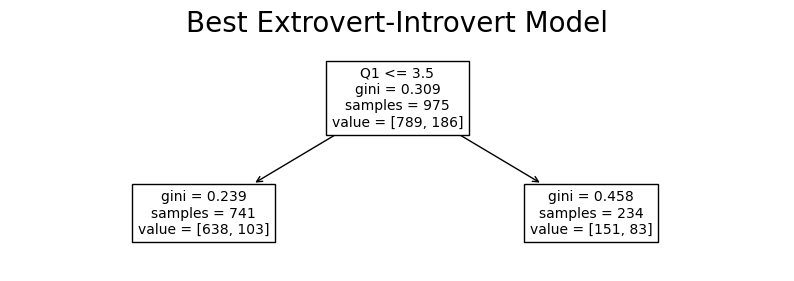

The best question to determine if someone values extrovert-introvert more is question #0:
gets worn out by parties; gets fired up by parties
My analysis: People who respond 'neutral' by being fired up by parties are more likely to be introverted than not, which is really interesting.
Across 50 random subsets of 20% of the data, this question differentiates between the dichotomy successfully 81.5655737704918% of the time. 


In [253]:
dichotomy_best_question("IE") # Enter IE or EI, TF or FT, SN or SN, JP or PJ

Sensing-Intuition
Training Accuracy Score 0.6871794871794872
Testing Accuracy Score 0.6721311475409836
DecisionTreeClassifier(max_depth=1, max_features=48, max_leaf_nodes=10,
                       min_samples_leaf=2, random_state=0)


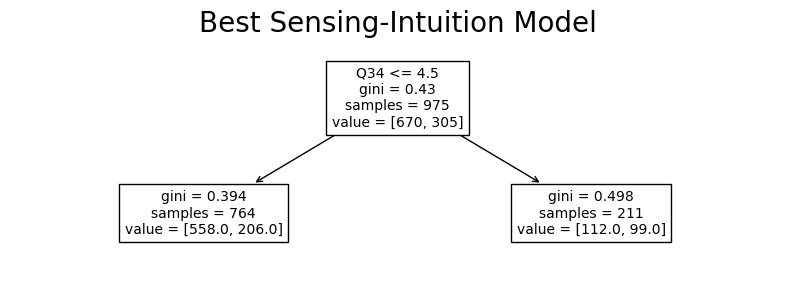

The best question to determine if someone values sensing-intuition more is question #33:
accepts things as they are; unsatisfied with the ways things are
My analysis: I am honestly surprised this was the best question.
Across 50 random subsets of 20% of the data, this question differentiates between the dichotomy successfully 68.15573770491804% of the time. 


In [254]:
dichotomy_best_question("SN") # Enter IE or EI, TF or FT, SN or SN, JP or PJ

Feeling-Thinking
Training Accuracy Score 0.7394871794871795
Testing Accuracy Score 0.7622950819672131
DecisionTreeClassifier(max_depth=1, max_features=48, max_leaf_nodes=10,
                       min_samples_leaf=2, random_state=0)


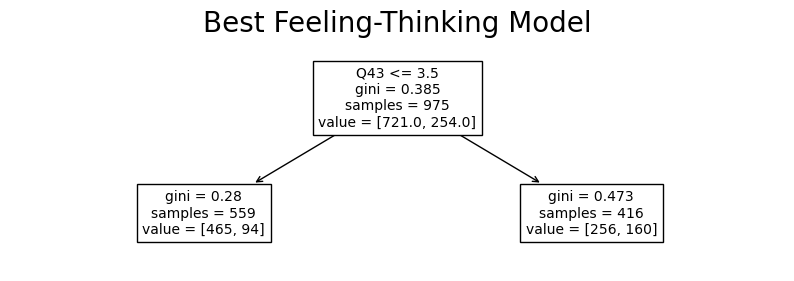

The best question to determine if someone values feeling-thinking more is question #42:
wants to be good at fixing things; wants to be good at fixing people
My analysis: It's interesting that responding neutrally to this question makes you more likely to be T instead of F.
Across 50 random subsets of 20% of the data, this question differentiates between the dichotomy successfully 74.41803278688525% of the time. 


In [255]:
dichotomy_best_question("FT") # Enter IE or EI, TF or FT, SN or SN, JP or PJ

Judging-Perceiving
Training Accuracy Score 0.7589743589743589
Testing Accuracy Score 0.8032786885245902
DecisionTreeClassifier(max_depth=1, max_features=48, max_leaf_nodes=10,
                       min_samples_leaf=2, random_state=0)


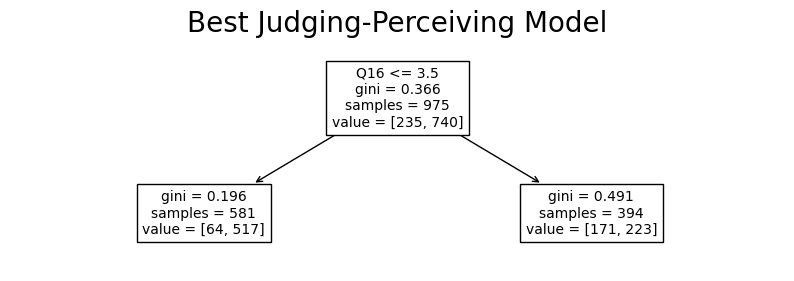

The best question to determine if someone values judging-perceiving more is question #15:
chaotic; organized
My analysis: Responding neutrally makes you more likely type P, and this makes sense. Most organized people KNOW they're organized.
Across 50 random subsets of 20% of the data, this question differentiates between the dichotomy successfully 76.85245901639344% of the time. 


In [256]:
dichotomy_best_question("JP") # Enter IE or EI, TF or FT, SN or SN, JP or PJ

# Additional Stats

In [263]:
confidence_index = column_names.index("confidenceintype")
mbti_nerds_index = column_names.index("prevhours") 
# 1=0-1 hours,  2= 2-5 hours,  3=6-20 hours,  4=21 or more 

# what percentage of test N = 1560 participants have dedicated 21 or more hours to MBTI typology?
obsessed_mbti_fans = all_data[:, mbti_nerds_index] == '4'
did_not_respond_to_hours = all_data[:, mbti_nerds_index] == '0'
# print(f"{100*np.average(did_not_respond_to_hours):.2f}% of participants did not respond to the hours question", )

very_confident_in_type = all_data[:, confidence_index] == '3'
confident_in_type = all_data[:, confidence_index] == '2'

print(f"{np.average(obsessed_mbti_fans)*100:.2f}% of N = {len(all_data)} participants have dedicated 21 or more hours to MBTI typology.")
print(f"{np.average(very_confident_in_type)*100:.2f}% of N = {len(all_data)} participants were 'very confident' in their MBTI type before seeing their results.")
print(f"{np.average(confident_in_type)*100:.2f}% of N = {len(all_data)} participants were 'confident' in their MBTI type before seeing their results.")

7.79% of N = 1219 participants have dedicated 21 or more hours to MBTI typology.
10.34% of N = 1219 participants were 'very confident' in their MBTI type before seeing their results.
44.05% of N = 1219 participants were 'confident' in their MBTI type before seeing their results.


# Limitations

- There is heavy self-selection bias in this report. While not included, the distributions of personality type for test takers differs dramatically from test-takers
  - Ex. there is an extremely high occurence of ISFJ (46.9%) after the participants who did not take the test properly were removed
- Test takers who already know what their MBTI type may be influenced by this in how they answer each question
  - 7.79% of participants who took the test correctly dedicated 21 or more hours to MBTI typology. These participants can easily determine which questions target which dichotomy, which could influence how they respond.

In [265]:
# Example of how self-selection bias is a limitation:
print("The coincidence between extroversion and thinking is HIGH. This has to due with the high sample size of ISFP")
print(f"{np.average(EI_type == FT_type)*100}% of Introverts are also of type F, for example")

# Participants who spent a lot of time already learning about MBTI
print(f"{np.average(obsessed_mbti_fans)*100:.2f}% of N = {len(all_data)} participants have dedicated 21 or more hours to MBTI typology.")

The coincidence between extroversion and thinking is HIGH. This has to due with the high sample size of ISFP
73.74897456931912% of Introverts are also of type F, for example
7.79% of N = 1219 participants have dedicated 21 or more hours to MBTI typology.


# Next Steps

### Moving forward, I want to find the best questions to determine a person's MBTI type within 0 or 1 dichotomies (either getting it completely right or missing it by one letter). While I already trained a naive model with about a 33% accuracy to determine MBTI with only 4/5 questions, I want to develop a model with higher accuracy.
### Given the uneven distribution of samples (particularly in ISFP), I want to either introduce class weighting or upsample less prevalent MBTI types to make the model more robust.